<a href="https://colab.research.google.com/github/Rithanya13/playstore_analytics/blob/main/notebooks/playstore_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install pandas numpy scikit-learn matplotlib seaborn kaggle --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# ─────── Unified loader for CSV or ZIP ───────

from google.colab import files
import pandas as pd
import io, zipfile

# 1️⃣ Upload your file (either .csv or .zip)
uploaded = files.upload()  # Click “Choose Files” and pick your googleplaystore.csv.zip

# 2️⃣ Grab the uploaded filename & bytes
fname = list(uploaded.keys())[0]
file_bytes = io.BytesIO(uploaded[fname])

# 3️⃣ If it’s a zip, unzip and read the first CSV inside;
#    otherwise read it directly.
if fname.lower().endswith('.zip'):
    with zipfile.ZipFile(file_bytes) as z:
        # assume there’s just one CSV in the zip
        csv_name = [n for n in z.namelist() if n.lower().endswith('.csv')][0]
        df = pd.read_csv(z.open(csv_name))
else:
    df = pd.read_csv(file_bytes)

# 4️⃣ Sanity check
df.head()

Saving googleplaystore.csv.zip to googleplaystore.csv (3).zip


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [35]:
import numpy as np
import pandas as pd

# ─── Step 3: Parse & Clean Key Columns ────────────────────────────────────

# 1. Reviews → integer (handle “M”/“k” suffixes, commas, and bad values)
def parse_reviews(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # Millions, e.g. "3.0M"
    if s.lower().endswith('m'):
        return float(s[:-1]) * 1e6
    # Thousands, e.g. "4.5k"
    if s.lower().endswith('k'):
        return float(s[:-1]) * 1e3
    # Plain number with commas
    s = s.replace(',', '')
    try:
        return float(s)
    except:
        return np.nan

df['Reviews'] = df['Reviews'].apply(parse_reviews)
df = df.dropna(subset=['Reviews']).copy()
df['Reviews'] = df['Reviews'].astype(int)

# 2. Installs → integer (remove commas & “+”), drop non-numeric
installs_clean = df['Installs'].str.replace(r'[+,]', '', regex=True)
bad_installs = installs_clean[~installs_clean.str.isdigit()].unique()
print("Non-numeric install entries:", bad_installs)  # e.g. ['Free']
mask = installs_clean.str.isdigit()
df = df[mask].copy()
df['Installs'] = installs_clean[mask].astype(int)

# 3. Price → float (strip “$”, coerce errors to 0)
df['Price'] = df['Price'].str.replace(r'^\$', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0.0)

# 4. Size → numeric MB
def parse_size(size):
    if pd.isna(size) or size == 'Varies with device':
        return np.nan
    s = size.strip()
    if s.endswith('M'):
        return float(s[:-1])
    if s.endswith('k'):
        return float(s[:-1]) / 1024
    return np.nan

df['Size'] = df['Size'].apply(parse_size)

# 5. Last Updated → datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], format='%B %d, %Y', errors='coerce')

# 6. Drop duplicates & impute Rating
df.drop_duplicates(subset=['App','Category','Last Updated'], inplace=True)
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# 7. Quick check
print(df.info())
df.head()

Non-numeric install entries: ['Free']
<class 'pandas.core.frame.DataFrame'>
Index: 9778 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             9778 non-null   object        
 1   Category        9778 non-null   object        
 2   Rating          9778 non-null   float64       
 3   Reviews         9778 non-null   int64         
 4   Size            8512 non-null   float64       
 5   Installs        9778 non-null   int64         
 6   Type            9777 non-null   object        
 7   Price           9778 non-null   float64       
 8   Content Rating  9778 non-null   object        
 9   Genres          9778 non-null   object        
 10  Last Updated    9778 non-null   datetime64[ns]
 11  Current Ver     9770 non-null   object        
 12  Android Ver     9776 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 1.0+ M

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


In [36]:
# ─── Step 4: Feature Engineering ─────────────────────────────────────────

import numpy as np

# 1. Log‑transform skewed features
df['log_Installs'] = np.log1p(df['Installs'])
df['log_Reviews']  = np.log1p(df['Reviews'])

# 2. Binary “is_free” flag from Price
df['is_free'] = (df['Price'] == 0.0).astype(int)

# 3. Days since last update
today = pd.to_datetime('today')
df['days_since_update'] = (today - df['Last Updated']).dt.days

# 4. Encode Category (one‑hot)
df = pd.get_dummies(df, columns=['Category'], prefix='cat', drop_first=True)

# 5. (Optional) Simplify Genres: take the first genre before “;”
df['Primary Genre'] = df['Genres'].str.split(';').str[0]
df = pd.get_dummies(df, columns=['Primary Genre'], prefix='genre', drop_first=True)

# 6. Quick peek at engineered features
print(df[['log_Installs','log_Reviews','is_free','days_since_update']].head())

   log_Installs  log_Reviews  is_free  days_since_update
0      9.210440     5.075174        1               2674
1     13.122365     6.875232        1               2666
2     15.424949    11.379520        1               2468
3     17.727534    12.281389        1               2522
4     11.512935     6.875232        1               2510


In [44]:
from sklearn.ensemble import RandomForestRegressor

# 1a. Define a new feature set that includes Price
feature_cols_price = feature_cols + ['Price']

# 1b. Prepare X & y
X_price = df[feature_cols_price]
y_price = df['log_Installs']

# 1c. (Optional) Drop any rows with NaNs in these features
mask_price = X_price.dropna().index
X_price = X_price.loc[mask_price]
y_price = y_price.loc[mask_price]

# 1d. Train a fresh Random Forest on **all** data
rf_price = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_price.fit(X_price, y_price)

print("Retrained Random Forest including Price. Feature set size:", X_price.shape[1])

Retrained Random Forest including Price. Feature set size: 83


In [45]:
# ─── Step 5: Modeling Setup ────────────────────────────────────────────────

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 1. Define features & target
feature_cols = ['log_Reviews', 'is_free', 'days_since_update'] \
               + [c for c in df.columns if c.startswith('cat_') or c.startswith('genre_')]
X = df[feature_cols]
y = df['log_Installs']

# 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 3. Train models
# 3a. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# 3b. Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 4. Quick training performance check
print("Linear Regression R² (train):", lr.score(X_train, y_train))
print("Random Forest R² (train):", rf.score(X_train, y_train))

Linear Regression R² (train): 0.9315345804981936
Random Forest R² (train): 0.9896112697871697


               Model  R2 (Test)  RMSE (Test)
0  Linear Regression   0.933217     1.154297
1      Random Forest   0.934076     1.146844


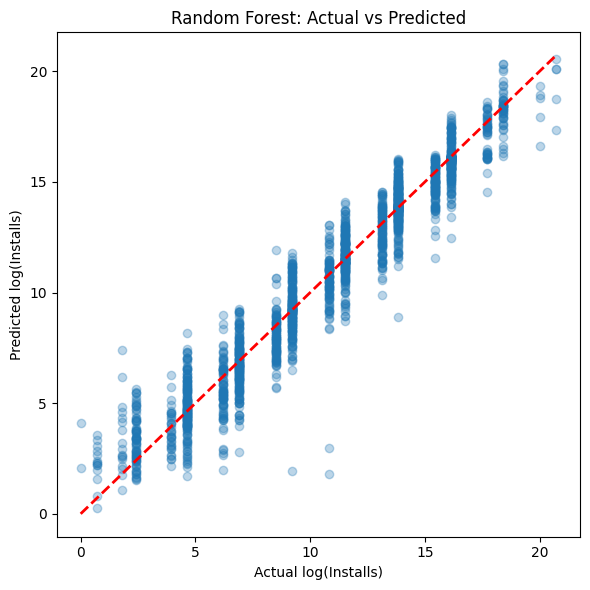

In [46]:
# ─── Step 6: Model Evaluation & Comparison ────────────────────────────────
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Generate predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# 2. Compute metrics
results = {
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 (Test)': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf)
    ],
    'RMSE (Test)': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf))
    ]
}
metrics_df = pd.DataFrame(results)
print(metrics_df)

# 3. Plot Actual vs. Predicted for Random Forest
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel('Actual log(Installs)')
plt.ylabel('Predicted log(Installs)')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

In [47]:
import pandas as pd

# Compute & sort importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# Display the top 10 features
print(feat_imp.head(10))

log_Reviews            0.940744
days_since_update      0.022356
is_free                0.009006
genre_Education        0.001104
cat_TOOLS              0.001011
genre_Tools            0.000964
cat_FAMILY             0.000874
genre_Casual           0.000820
cat_GAME               0.000701
genre_Entertainment    0.000684
dtype: float64


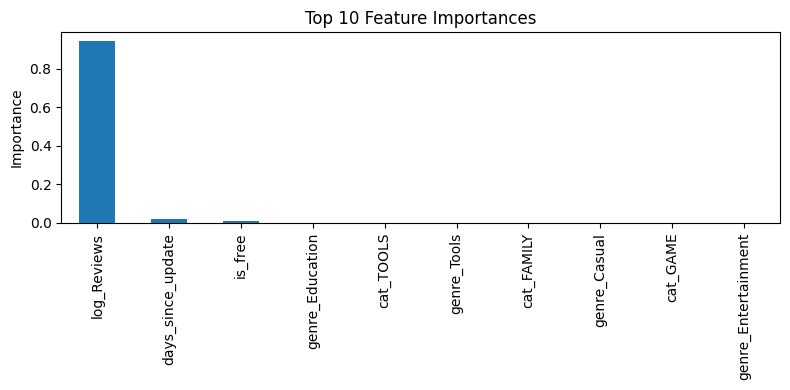

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
feat_imp.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

               Model  R2 (Test)  RMSE (Test)
0  Linear Regression   0.040793     0.495637
1      Random Forest   0.028942     0.498689


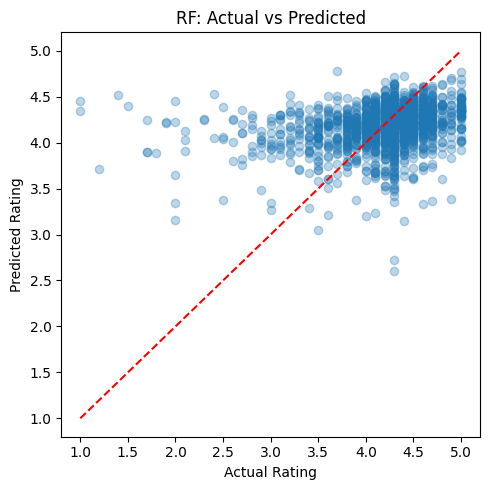

In [49]:
# ─── Q2: Rating Prediction – Drop NaNs, Train & Evaluate ─────────────────
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Define features & target (after your cleaning/engineering)
feats = ['log_Reviews', 'is_free', 'days_since_update', 'Price', 'Size'] \
      + [c for c in df.columns if c.startswith('cat_') or c.startswith('genre_')]
X2 = df[feats]
y2 = df['Rating']

# 1. Drop rows with any NaNs in X2
X2_clean = X2.dropna()
y2_clean = y2.loc[X2_clean.index]

# 2. Split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_clean, y2_clean, test_size=0.2, random_state=42
)

# 3. Initialize & fit
lr2 = LinearRegression()
rf2 = RandomForestRegressor(random_state=42, n_jobs=-1)

lr2.fit(X2_train, y2_train)
rf2.fit(X2_train, y2_train)

# 4. Predict & evaluate
y2_pred_lr = lr2.predict(X2_test)
y2_pred_rf = rf2.predict(X2_test)

results2 = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest'],
    'R2 (Test)': [
        r2_score(y2_test, y2_pred_lr),
        r2_score(y2_test, y2_pred_rf)
    ],
    'RMSE (Test)': [
        np.sqrt(mean_squared_error(y2_test, y2_pred_lr)),
        np.sqrt(mean_squared_error(y2_test, y2_pred_rf))
    ]
})
print(results2)

# 5. Optional: plot RF
plt.figure(figsize=(5,5))
plt.scatter(y2_test, y2_pred_rf, alpha=0.3)
plt.plot([y2_test.min(),y2_test.max()],[y2_test.min(),y2_test.max()],'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('RF: Actual vs Predicted')
plt.tight_layout()
plt.show()

Top 10 Features for Rating Prediction:
log_Reviews               0.255858
days_since_update         0.239027
Size                      0.200049
Price                     0.021662
genre_Education           0.013858
genre_Entertainment       0.012072
cat_FAMILY                0.009741
genre_Lifestyle           0.008293
cat_HEALTH_AND_FITNESS    0.008154
cat_LIFESTYLE             0.008137
dtype: float64


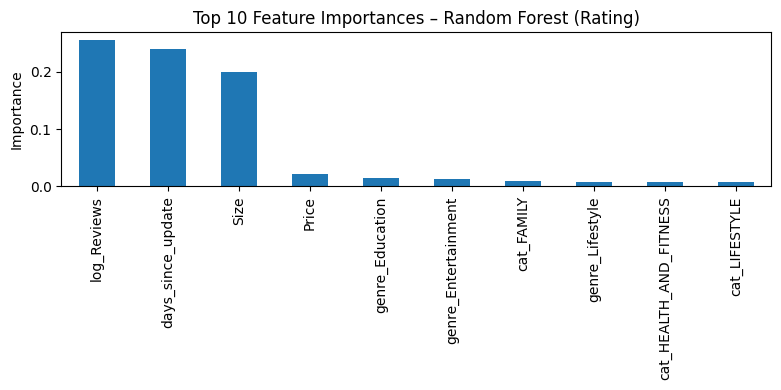

In [50]:
# ─── Rating Prediction: Feature Importances ───────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt

# Assuming feats and rf2 are in your workspace:
importances2 = rf2.feature_importances_
feat_imp2 = pd.Series(importances2, index=feats).sort_values(ascending=False)

# 1. Display top 10
print("Top 10 Features for Rating Prediction:")
print(feat_imp2.head(10))

# 2. Bar chart
plt.figure(figsize=(8,4))
feat_imp2.head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances – Random Forest (Rating)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

🔍 Optimal Price: $9.99
Price           9.990000e+00
TotalRevenue    5.272761e+08
AvgRevenue      6.956149e+05
Name: 9, dtype: float64


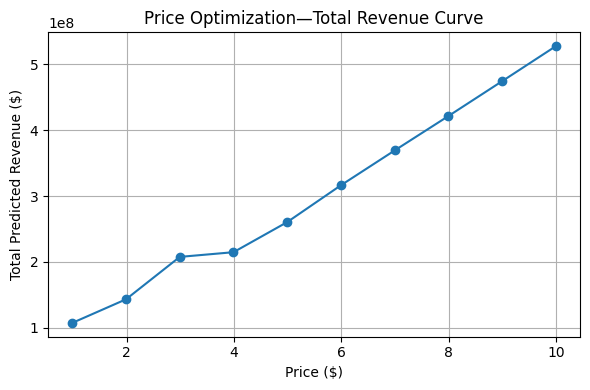

In [51]:
# ─── Q3: Price‑Optimization Simulation (with Price in model) ────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Subset to paid apps
df_paid = df[df['is_free'] == 0].copy()

# Use the retrained feature list
features_installs = feature_cols_price  # now includes ‘Price’

price_grid = np.arange(0.99, 10.00, 1.00)
results = []

for price in price_grid:
    X_sim = df_paid[features_installs].copy()
    X_sim['Price'] = price                       # override price
    log_installs_pred = rf_price.predict(X_sim)  # use rf_price here
    installs_pred    = np.expm1(log_installs_pred)
    revenue          = installs_pred * price
    results.append({
        'Price': price,
        'TotalRevenue': revenue.sum(),
        'AvgRevenue':   revenue.mean()
    })

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['TotalRevenue'].idxmax()]

print(f"🔍 Optimal Price: ${best.Price:.2f}")
print(best)

plt.figure(figsize=(6,4))
plt.plot(results_df['Price'], results_df['TotalRevenue'], marker='o')
plt.xlabel('Price ($)')
plt.ylabel('Total Predicted Revenue ($)')
plt.title('Price Optimization—Total Revenue Curve')
plt.grid(True)
plt.tight_layout()
plt.show()

Retrained on 758 paid apps with 84 features
🔍 New Realistic Optimal Price: $9.99
Price           9.990000e+00
TotalRevenue    3.494632e+08
Name: 9, dtype: float64


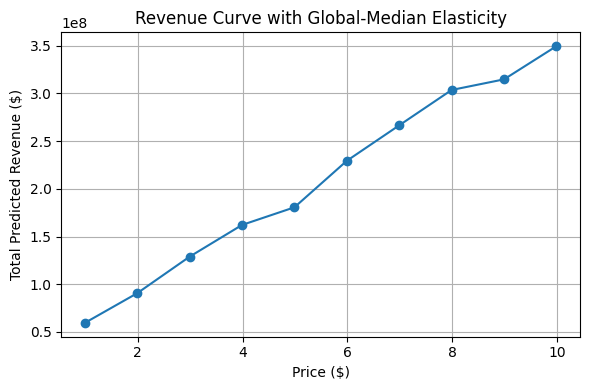

In [63]:
# ─── Elasticity via Global Median & Price‑Opt Simulation ──────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1. Subset to paid apps only
df_paid = df[df['is_free'] == 0].copy()

# 2. Compute global median price among paid apps
global_median_price = df_paid['Price'].median()

# 3. Elasticity feature: price vs. global median
df_paid['price_vs_global_median'] = df_paid['Price'] / global_median_price

# 4. Define install‑model features including Price & new elasticity
feature_cols_elastic = feature_cols + ['Price', 'price_vs_global_median']

# 5. Prepare training data (drop NaNs)
X_e = df_paid[feature_cols_elastic].dropna()
y_e = df_paid.loc[X_e.index, 'log_Installs']

# 6. Retrain Random Forest on paid apps
rf_elastic = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_elastic.fit(X_e, y_e)
print(f"Retrained on {X_e.shape[0]} paid apps with {len(feature_cols_elastic)} features")

# 7. Price‑Optimization Simulation
price_grid = np.arange(0.99, 10.00, 1.00)
results = []
for p in price_grid:
    X_sim = X_e.copy()
    X_sim['Price'] = p
    X_sim['price_vs_global_median'] = p / global_median_price
    log_installs = rf_elastic.predict(X_sim)
    installs     = np.expm1(log_installs)
    revenue      = installs * p
    results.append({'Price': p, 'TotalRevenue': revenue.sum()})

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['TotalRevenue'].idxmax()]
print(f"🔍 New Realistic Optimal Price: ${best.Price:.2f}")
print(best)

# 8. Plot the curve
plt.figure(figsize=(6,4))
plt.plot(results_df['Price'], results_df['TotalRevenue'], marker='o')
plt.xlabel('Price ($)')
plt.ylabel('Total Predicted Revenue ($)')
plt.title('Revenue Curve with Global‑Median Elasticity')
plt.grid(True)
plt.tight_layout()
plt.show()